This notebook was used to inform paramterization of the linear mixed models in 04.2. 

# Data Cleaning & Script Setup

In [1]:
library(dplyr)
library(tidyverse)

Warning message:
“package ‘dplyr’ was built under R version 3.6.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 3.6.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.1
✔ readr   1.4.0     

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘tibble’ was built under R version 3.6.3”
Warning message:
“package ‘tidyr’ was built under R version 3.6.3”
Warning message:
“package 

In [2]:
# read in metadata
vif_meta <- read.csv("./df/vitis_ionomics_meta.csv")
# read in data
vif_data <- read.csv("./df/vif_k10.csv")

vif_data <- vif_data  %>% rename(B=B11, Na=Na23, Mg=Mg26, Al=Al27, P=P31, S=S34, K=K39, Ca=Ca44, 
                                 Fe=Fe54, Mn=Mn55, Co=Co59, Ni=Ni60, Cu=Cu63, Zn=Zn66, As=As75, 
                                 Se=Se78, Rb=Rb85, Sr=Sr88, Mo=Mo98, Cd=Cd111)

# Merge metadata and data to new df
vif <- merge(vif_meta, vif_data, on='samplename')

# These are all the duplciate values
dupes <- as.data.frame(table(vif$samplename)[table(vif$samplename) > 1])
dupes

# Set row number to sample name- for consistency
rownames(vif) <- vif$samplename
vif$row <- as.factor(vif$row)
vif$block <- as.factor(vif$block)
vif$year <- as.factor(vif$year)

# remove when there is a Z for replicate (invalid data)
vif <- vif[-c(which(vif$replicate == 'Z')), ]
# remove when leafposition is set to F (invalid data)
vif <- vif[-c(which(vif$leafpos == 'F')), ]
# capitalize the Z in leafposition (change to valid data)
vif$leafpos[which(vif$leafpos == 'z')] <- 'Z'

# refactor
vif$leafpos <- factor(vif$leafpos, levels=c('X', 'Y', 'Z'))
vif$rootstock <- factor(vif$rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4'))
vif$treatment <- factor(vif$treatment, levels=c('None', 'RDI', 'Full'))
vif$phenology <- factor(vif$phenology, levels=c('anthesis','veraison','harvest'), labels=c('Anthesis', 'Veraison', 'Harvest'))

table(vif$samplename)[table(vif$samplename) > 1]

In [3]:
dim(vif)

[1] 7328   31

In [4]:
library('anomalize')
library('igraph')
library('corrplot')
library('MASS')
library("caret")
library('rebus')
library('viridis')
library('caret')


══ Use anomalize to improve your Forecasts by 50%! ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
Business Science offers a 1-hour course - Lab #18: Time Series Anomaly Detection!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>


Attaching package: ‘igraph’


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message:
“package ‘corrplot’ was built under R version 3.6.3”
corrplot 0.84 loaded

Warning message:
“package ‘MASS’ was built under R v

In [5]:
install.packages('e1071')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [6]:
# rootstock, phenology, year, leafpos, irrigation, row, block
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
y_palette <- c('dodgerblue4', 'springgreen1', 'plum1')
l_palette <- c(rgb(145,102,189,maxColorValue=255),rgb(178,76,76,maxColorValue=255),rgb(0,146,146,maxColorValue=255))
i_palette <- c('grey', 'lightblue', 'darkblue')
r_palette <- viridisLite::viridis(9)
b_palette <- c('lightgoldenrod1', 'lightgoldenrod2', 'darkgoldenrod1', 'darkgoldenrod2', 'darkgoldenrod3', 'darkgoldenrod4')

# LDA

### set up

In [7]:
data <- vif %>% dplyr::select(B:Cd, samplename, treatment)

# separate into 80/20 train/test split
idx <- 1:dim(data)[1]
train_idx <- sort(sample(idx, size=ceiling(length(idx)*0.8), replace=F))
test_idx <- sort(idx[!(idx %in% train_idx)])

### irrigation

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


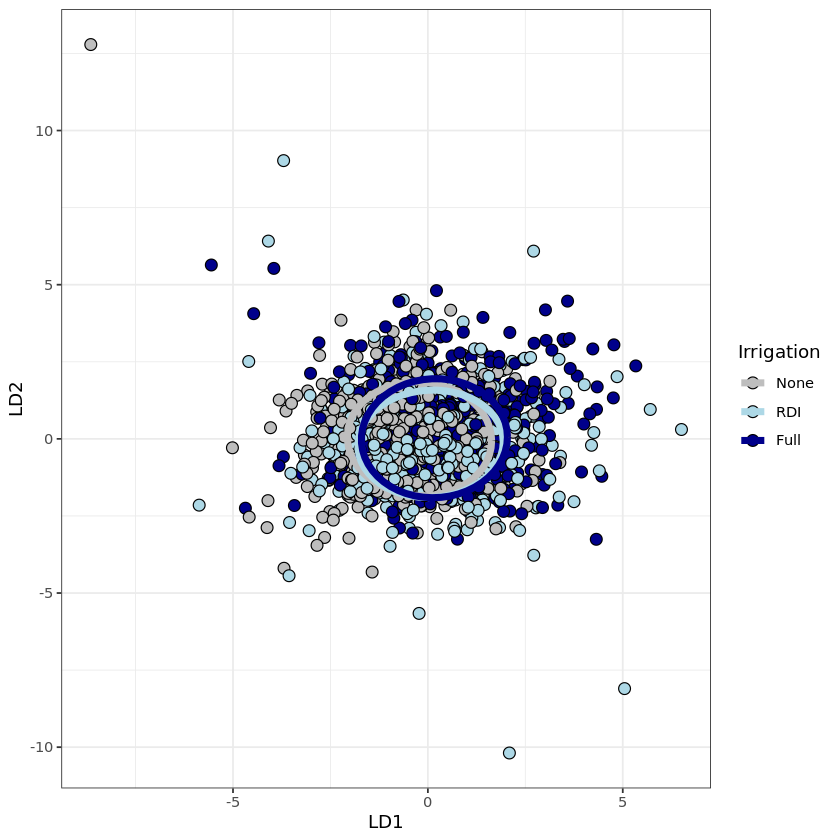

png 
  2

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


png 
  2

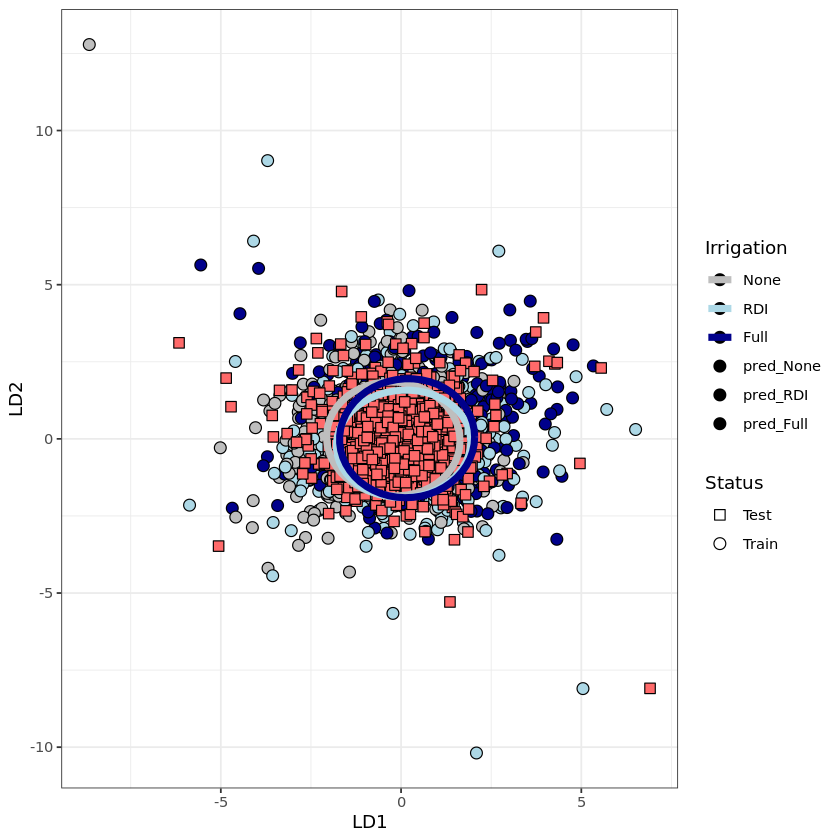

In [8]:
# select only ions, remove columns with NA
data <- vif %>% dplyr::select(B:Cd, samplename, treatment)

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$treatment
y_test <- X_test$treatment

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$treatment <- NULL
X_test$treatment <- NULL

# viz
lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Irrigation <- y_train

lda.irrigation <- ggplot(d, aes(x=LD1, y=LD2, fill=Irrigation, shape=Irrigation)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 3)) + 
  scale_fill_manual(values=i_palette) + 
  stat_ellipse(aes(color=Irrigation), lwd=2) + 
  scale_color_manual(values=i_palette) + 
  theme_bw()
lda.irrigation

# pred
pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Irrigation <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Irrigation <- factor(d_pred$Irrigation, levels=c('None', 'RDI', 'Full', 'pred_None', 'pred_RDI', 'pred_Full'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.irrigation.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Irrigation, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(i_palette, 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Irrigation), lwd=2) + 
  scale_color_manual(values=c(i_palette, NA, NA, NA)) + 
  theme_bw()
lda.irrigation.pred

pdf('figures/LDA/lda_irrigation.pdf')
  lda.irrigation
dev.off()
pdf('figures/LDA/lda_irrigation_pred.pdf')
  lda.irrigation.pred
dev.off()

In [9]:
getwd()

[1] "/mnt/c/Users/Julia/Desktop/Aim1_Ionomics/171819_ionomics_analysis_complete"

In [10]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
irrigation_overall <- as.data.frame(cm$overall)
irrigation_byclass <- as.data.frame(cm$byClass)
write.csv(irrigation_overall,file="figures/LDA/lda_irrigation_cm_overall.csv")
write.csv(irrigation_byclass,file="figures/LDA/lda_irrigation_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction None RDI Full
      None  232 106  123
      RDI   175 162  178
      Full  165 144  180

Overall Statistics
                                          
               Accuracy : 0.3918          
                 95% CI : (0.3667, 0.4173)
    No Information Rate : 0.3904          
    P-Value [Acc > NIR] : 0.4672          
                                          
                  Kappa : 0.0905          
                                          
 Mcnemar's Test P-Value : 6.943e-06       

Statistics by Class:

                     Class: None Class: RDI Class: Full
Sensitivity               0.4056     0.3932      0.3742
Specificity               0.7436     0.6648      0.6860
Pos Pred Value            0.5033     0.3146      0.3681
Neg Pred Value            0.6614     0.7368      0.6916
Prevalence                0.3904     0.2812      0.3283
Detection Rate            0.1584     0.1106      0.1229
Detection Prevalence     

### block

Warning message:
“Removed 312 row(s) containing missing values (geom_path).”


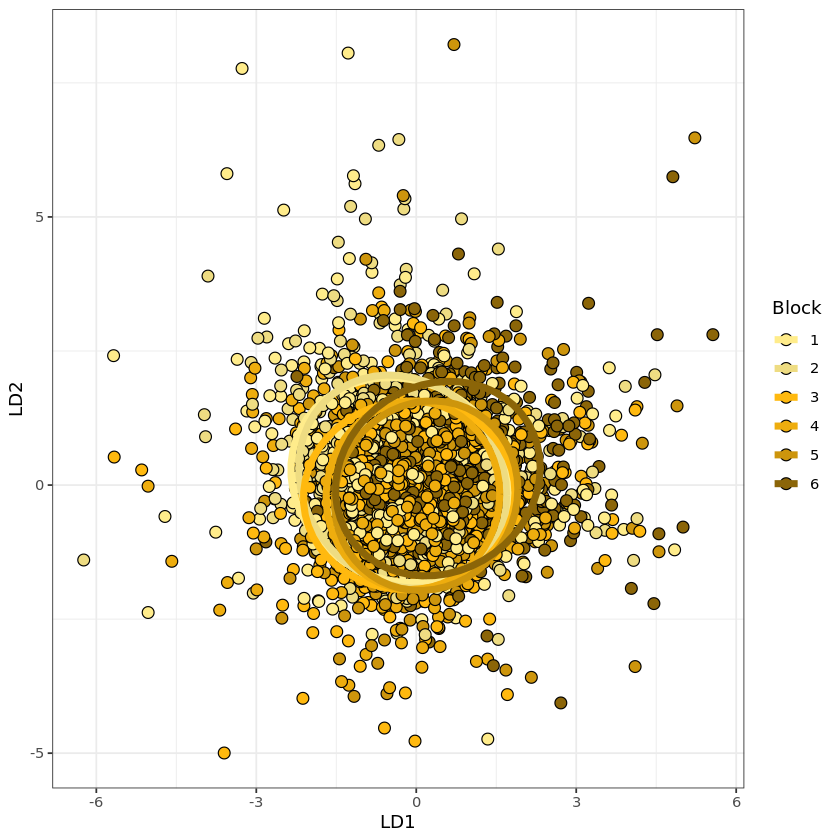

png 
  2

Warning message:
“Removed 312 row(s) containing missing values (geom_path).”


png 
  2

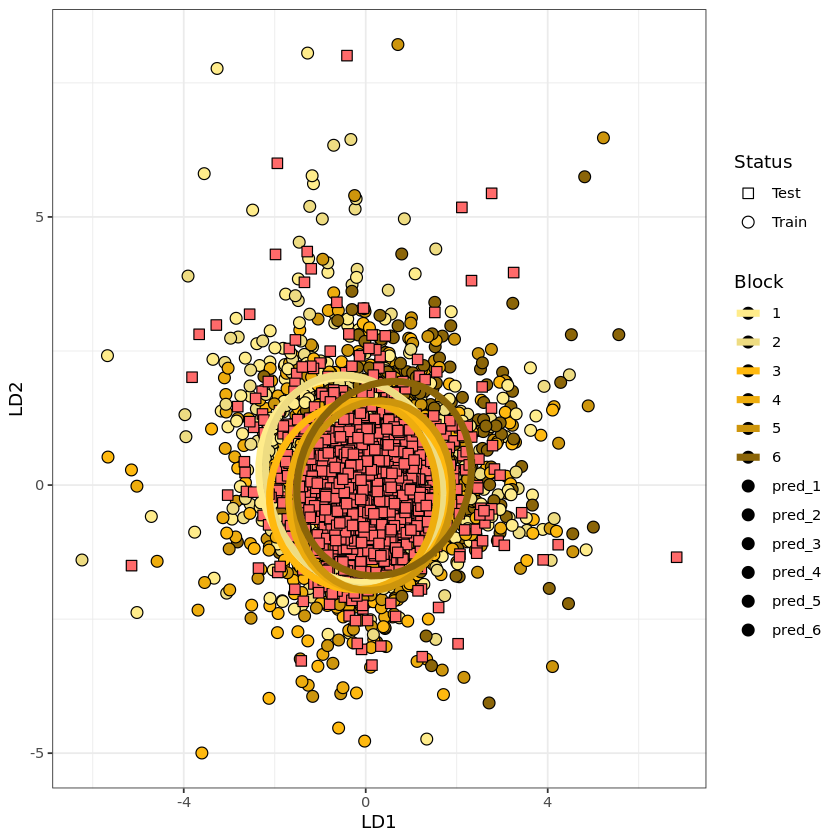

In [11]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, block)

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$block
y_test <- X_test$block

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$block <- NULL
X_test$block <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Block <- y_train

lda.block <- ggplot(d, aes(x=LD1, y=LD2, fill=Block, shape=Block)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 6)) + 
  scale_fill_manual(values=b_palette) + 
  stat_ellipse(aes(color=Block), lwd=2) + 
  scale_color_manual(values=b_palette) + 
  theme_bw()
lda.block

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Block <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Block <- factor(d_pred$Block, levels=c('1', '2', '3', '4', '5', '6', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.block.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Block, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(b_palette, 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Block), lwd=2) + 
  scale_color_manual(values=c(b_palette, NA, NA, NA, NA, NA, NA)) + 
  theme_bw()
lda.block.pred

pdf('figures/LDA/lda_block.pdf')
  lda.block
dev.off()
pdf('figures/LDA/lda_block_pred.pdf')
  lda.block.pred
dev.off()


In [12]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
block_overall <- as.data.frame(cm$overall)
block_byclass <- as.data.frame(cm$byClass)
write.csv(block_overall,file="figures/LDA/lda_block_cm_overall.csv")
write.csv(block_byclass,file="figures/LDA/lda_block_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4  5  6
         1 53 54 47 35 22 51
         2 38 53 50 45 40 22
         3 31 33 54 35 30 44
         4 27 24 62 51 57 43
         5 27 17 51 35 57 45
         6 29 11 48 24 39 81

Overall Statistics
                                          
               Accuracy : 0.2382          
                 95% CI : (0.2166, 0.2609)
    No Information Rate : 0.213           
    P-Value [Acc > NIR] : 0.01062         
                                          
                  Kappa : 0.0874          
                                          
 Mcnemar's Test P-Value : 1.919e-07       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity           0.25854  0.27604  0.17308  0.22667  0.23265  0.28322
Specificity           0.83413  0.84682  0.84996  0.82823  0.85656  0.87193
Pos Pred Value        0.20229  0.21371  0.23789  0.19318  0.24569  0.34914
Neg Pred Value

### row

Warning message:
“Removed 468 row(s) containing missing values (geom_path).”


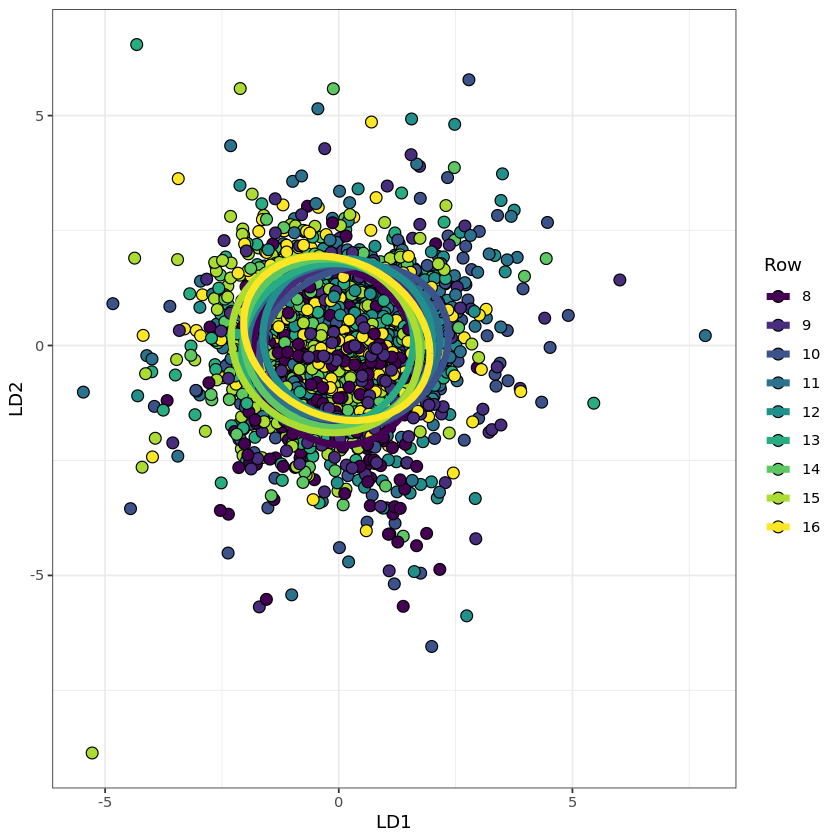

png 
  2

Warning message:
“Removed 468 row(s) containing missing values (geom_path).”


png 
  2

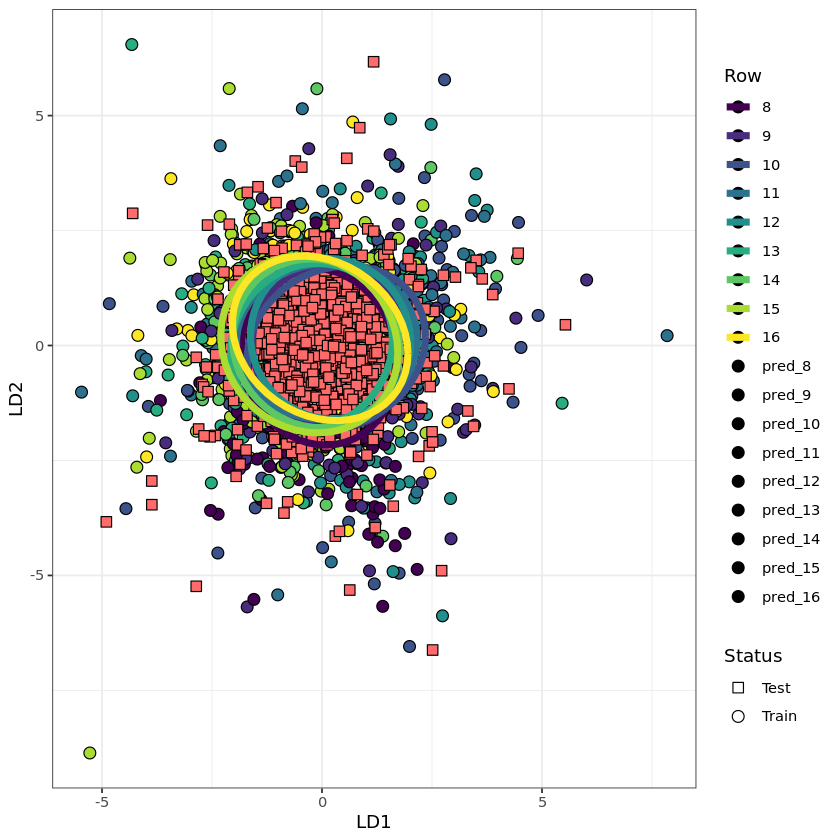

In [13]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, row)

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$row
y_test <- X_test$row

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$row <- NULL
X_test$row <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Row <- y_train

lda.row <- ggplot(d, aes(x=LD1, y=LD2, fill=Row, shape=Row)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 9)) + 
  scale_fill_manual(values=viridis(9)) + 
  stat_ellipse(aes(color=Row), lwd=2) + 
  scale_color_manual(values=viridis(9)) + 
  theme_bw()
lda.row

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Row <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Row <- factor(d_pred$Row, levels=c('8', '9', '10', '11', '12', '13', '14', '15', '16', 'pred_8', 'pred_9', 'pred_10', 'pred_11', 'pred_12', 'pred_13', 'pred_14', 'pred_15', 'pred_16'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.row.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Row, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(viridis(9), 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Row), lwd=2) + 
  scale_color_manual(values=c(viridis(9), NA, NA, NA, NA, NA, NA, NA, NA, NA)) + 
  theme_bw()
lda.row.pred

pdf('figures/LDA/lda_row.pdf')
  lda.row
dev.off()
pdf('figures/LDA/lda_row_pred.pdf')
  lda.row.pred
dev.off()

In [14]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
row_overall <- as.data.frame(cm$overall)
row_byclass <- as.data.frame(cm$byClass)
write.csv(row_overall,file="figures/LDA/lda_row_cm_overall.csv")
write.csv(row_byclass,file="figures/LDA/lda_row_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction  8  9 10 11 12 13 14 15 16
        8  40 18 10  7 12 16 11 28 23
        9  33 26 22 18 17  5 10 23 29
        10 20 29 15 27 22 10  7 28 20
        11 32 29 13 24 27 10  7 21 15
        12 15 14 17 21 26 11 10 19 20
        13 25 22  7  9 16 14  7 33 16
        14 20 16 11 13 15 16 15 27 21
        15 19 10 16 12 12  8 14 39 17
        16 14 18 13 14 19  9 20 25 26

Overall Statistics
                                          
               Accuracy : 0.1536          
                 95% CI : (0.1355, 0.1731)
    No Information Rate : 0.1659          
    P-Value [Acc > NIR] : 0.9041          
                                          
                  Kappa : 0.048           
                                          
 Mcnemar's Test P-Value : 2.285e-08       

Statistics by Class:

                     Class: 8 Class: 9 Class: 10 Class: 11 Class: 12 Class: 13
Sensitivity            0.1835  0.14286   0.12097   0.16552

### phenology

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


png 
  2

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


png 
  2

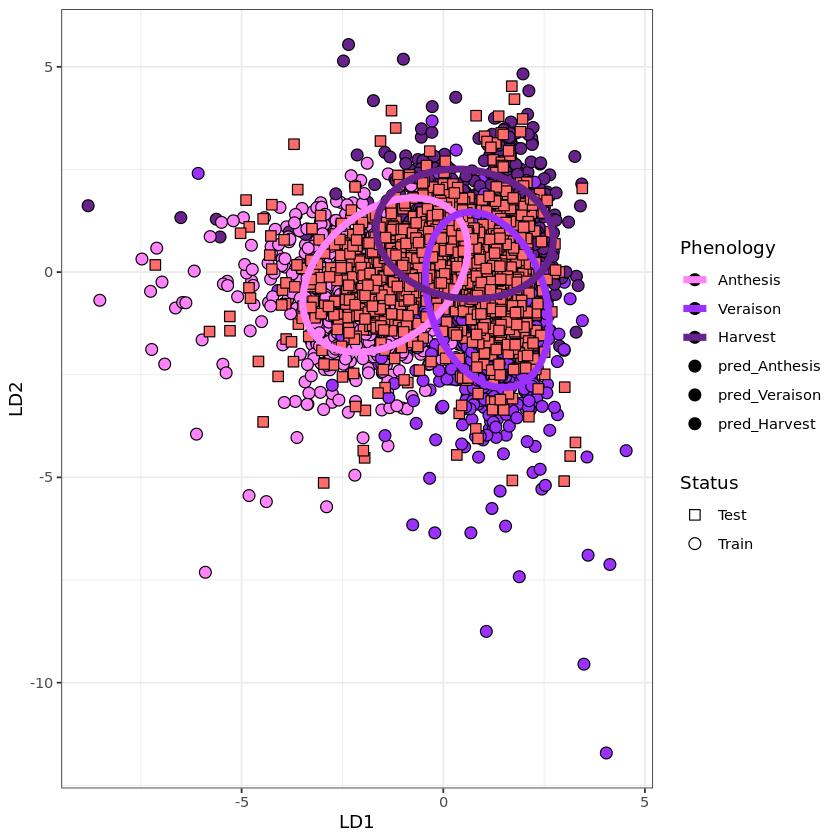

In [15]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, phenology)

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$phenology
y_test <- X_test$phenology

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$phenology <- NULL
X_test$phenology <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Phenology <- y_train

lda.pheno <- ggplot(d, aes(x=LD1, y=LD2, fill=Phenology, shape=Phenology)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 3)) + 
  scale_fill_manual(values=p_palette) + 
  stat_ellipse(aes(color=Phenology), lwd=2) + 
  scale_color_manual(values=p_palette) + 
  theme_bw()

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Phenology <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Phenology <- factor(d_pred$Phenology, levels=c('Anthesis', 'Veraison', 'Harvest', 'pred_Anthesis', 'pred_Veraison', 'pred_Harvest'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.pheno.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Phenology, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(p_palette, 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Phenology), lwd=2) + 
  scale_color_manual(values=c(p_palette, NA, NA, NA)) + 
  theme_bw()
lda.pheno.pred

pdf('figures/LDA/lda_pheno.pdf')
  lda.pheno
dev.off()
pdf('figures/LDA/lda_pheno_pred.pdf')
  lda.pheno.pred
dev.off()

In [16]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
pheno_overall <- as.data.frame(cm$overall)
pheno_byclass <- as.data.frame(cm$byClass)
write.csv(pheno_overall,file="figures/LDA/lda_pheno_cm_overall.csv")
write.csv(pheno_byclass,file="figures/LDA/lda_pheno_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction Anthesis Veraison Harvest
  Anthesis      454        8      51
  Veraison       28      383      83
  Harvest        27       47     384

Overall Statistics
                                          
               Accuracy : 0.8334          
                 95% CI : (0.8134, 0.8522)
    No Information Rate : 0.3536          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7503          
                                          
 Mcnemar's Test P-Value : 2.901e-06       

Statistics by Class:

                     Class: Anthesis Class: Veraison Class: Harvest
Sensitivity                   0.8919          0.8744         0.7413
Specificity                   0.9383          0.8919         0.9219
Pos Pred Value                0.8850          0.7753         0.8384
Neg Pred Value                0.9422          0.9434         0.8669
Prevalence                   

### leafpos

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


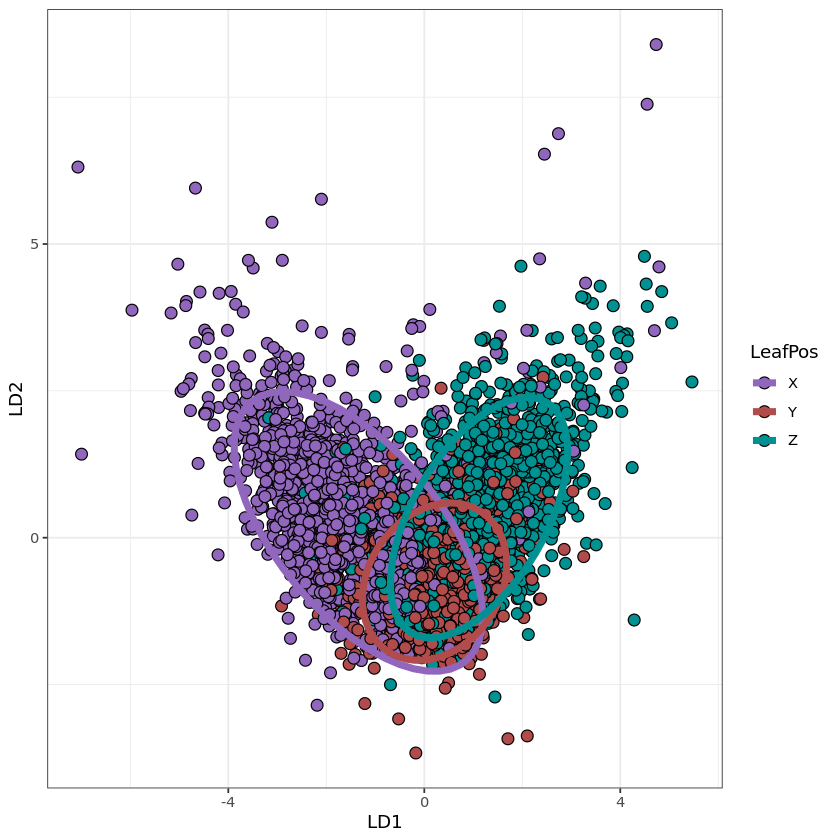

png 
  2

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


png 
  2

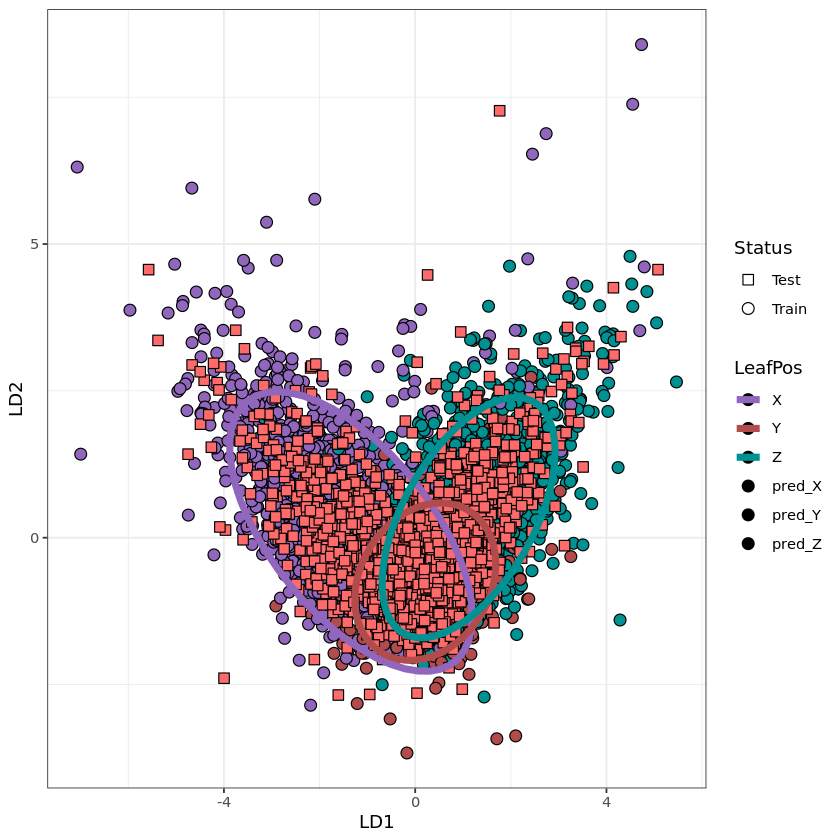

In [17]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, leafpos)

# separate into 80/20 train/test split
X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$leafpos
y_test <- X_test$leafpos

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$leafpos <- NULL
X_test$leafpos <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$LeafPos <- y_train

lda.leafpos <- ggplot(d, aes(x=LD1, y=LD2, fill=LeafPos, shape=LeafPos)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 3)) + 
  scale_fill_manual(values=l_palette) + 
  stat_ellipse(aes(color=LeafPos), lwd=2) + 
  scale_color_manual(values=l_palette) + 
  theme_bw()
lda.leafpos

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$LeafPos <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$LeafPos <- factor(d_pred$LeafPos, levels=c('X', 'Y', 'Z', 'pred_X', 'pred_Y', 'pred_Z'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.leafpos.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=LeafPos, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(l_palette, 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=LeafPos), lwd=2) + 
  scale_color_manual(values=c(l_palette, NA, NA, NA)) + 
  theme_bw()
lda.leafpos.pred

pdf('figures/LDA/lda_leafpos.pdf')
  lda.leafpos
dev.off()
pdf('figures/LDA/lda_leafpos_pred.pdf')
  lda.leafpos.pred
dev.off()

In [18]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
leafpos_overall <- as.data.frame(cm$overall)
leafpos_byclass <- as.data.frame(cm$byClass)
write.csv(leafpos_overall,file="figures/LDA/lda_leafpos_cm_overall.csv")
write.csv(leafpos_byclass,file="figures/LDA/lda_leafpos_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction   X   Y   Z
         X 323 146  11
         Y  51 374  74
         Z  15 102 369

Overall Statistics
                                          
               Accuracy : 0.7276          
                 95% CI : (0.7041, 0.7503)
    No Information Rate : 0.4246          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5908          
                                          
 Mcnemar's Test P-Value : 5.183e-11       

Statistics by Class:

                     Class: X Class: Y Class: Z
Sensitivity            0.8303   0.6013   0.8128
Specificity            0.8541   0.8517   0.8843
Pos Pred Value         0.6729   0.7495   0.7593
Neg Pred Value         0.9330   0.7433   0.9132
Prevalence             0.2655   0.4246   0.3099
Detection Rate         0.2205   0.2553   0.2519
Detection Prevalence   0.3276   0.3406   0.3317
Balanced Accuracy      0.8422   0.7265   

### year

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


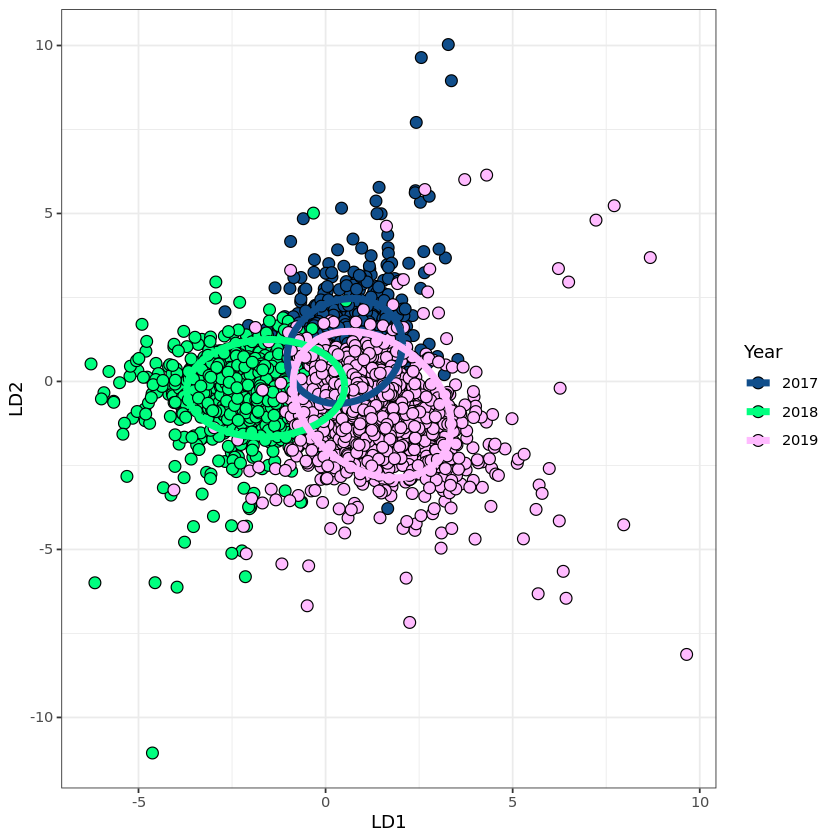

png 
  2

Warning message:
“Removed 156 row(s) containing missing values (geom_path).”


png 
  2

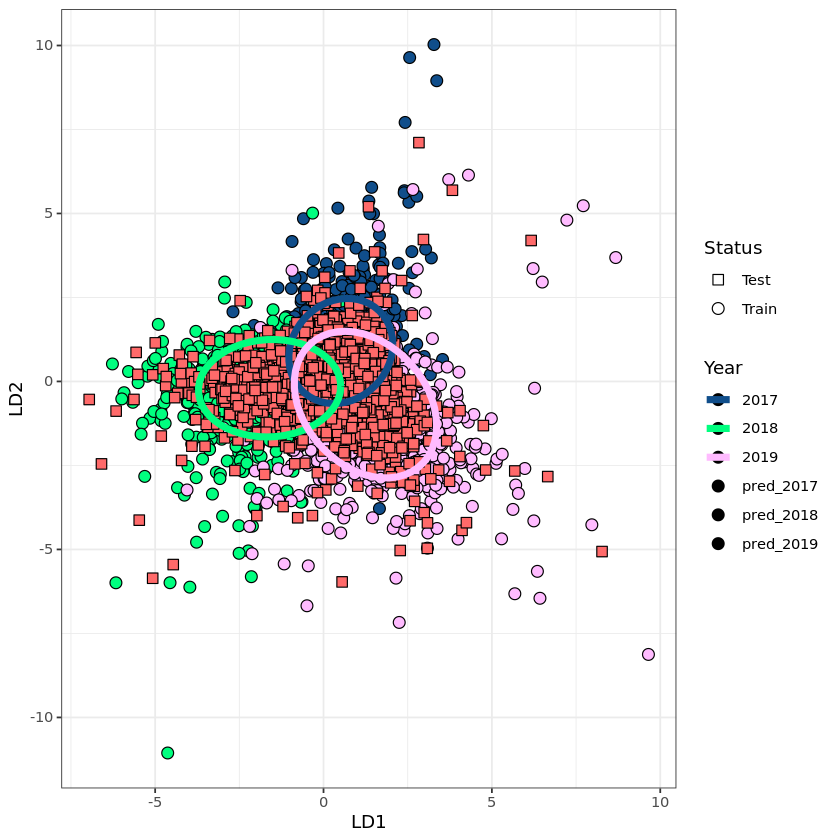

In [19]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, year)

# separate into 80/20 train/test split
X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$year
y_test <- X_test$year

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$year <- NULL
X_test$year <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Year <- y_train

lda.year <- ggplot(d, aes(x=LD1, y=LD2, fill=Year, shape=Year)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 3)) + 
  scale_fill_manual(values=y_palette) + 
  stat_ellipse(aes(color=Year), lwd=2) + 
  scale_color_manual(values=y_palette) + 
  theme_bw()
lda.year

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Year <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Year <- factor(d_pred$Year, levels=c('2017', '2018', '2019', 'pred_2017', 'pred_2018', 'pred_2019'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.year.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Year, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(y_palette, 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Year), lwd=2) + 
  scale_color_manual(values=c(y_palette, NA, NA, NA)) + 
  theme_bw()
lda.year.pred

pdf('figures/LDA/lda_year_pred.pdf')
  lda.year
dev.off()
pdf('figures/LDA/lda_year_pred.pdf')
  lda.year.pred
dev.off()

In [20]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
year_overall <- as.data.frame(cm$overall)
year_byclass <- as.data.frame(cm$byClass)
write.csv(year_overall,file="figures/LDA/lda_year_cm_overall.csv")
write.csv(year_byclass,file="figures/LDA/lda_year_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction 2017 2018 2019
      2017  430   31   42
      2018   49  424    8
      2019   94   24  363

Overall Statistics
                                          
               Accuracy : 0.8307          
                 95% CI : (0.8105, 0.8496)
    No Information Rate : 0.3911          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7457          
                                          
 Mcnemar's Test P-Value : 5.408e-07       

Statistics by Class:

                     Class: 2017 Class: 2018 Class: 2019
Sensitivity               0.7504      0.8852      0.8789
Specificity               0.9182      0.9422      0.8878
Pos Pred Value            0.8549      0.8815      0.7547
Neg Pred Value            0.8514      0.9441      0.9492
Prevalence                0.3911      0.3270      0.2819
Detection Rate            0.2935      0.2894      0.2478
Detection Prev

### rootstock

##### ld1 x ld2

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


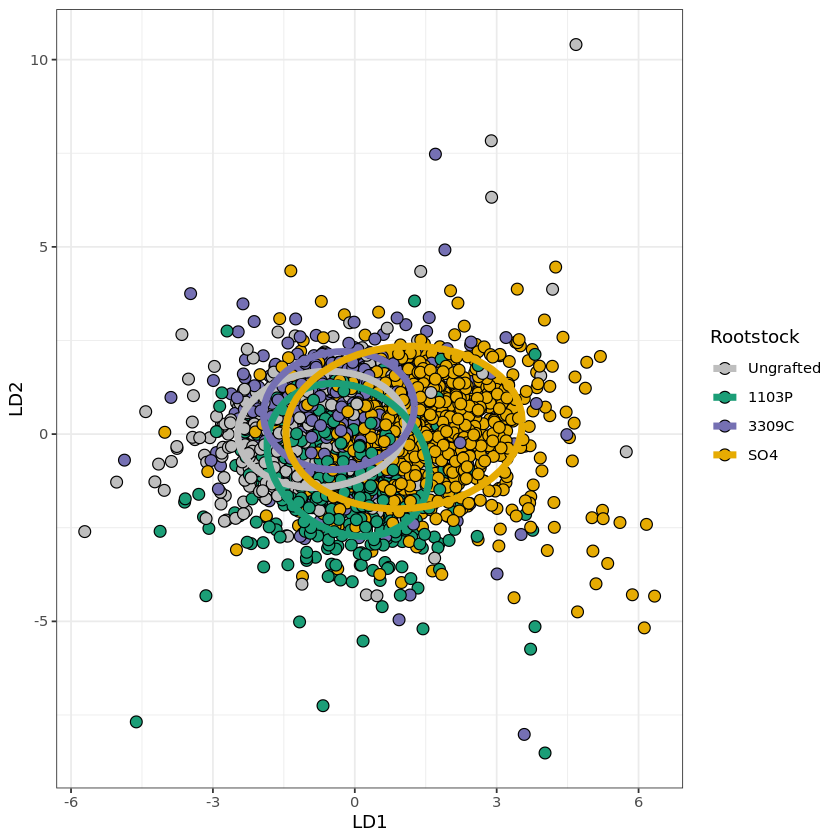

png 
  2

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


png 
  2

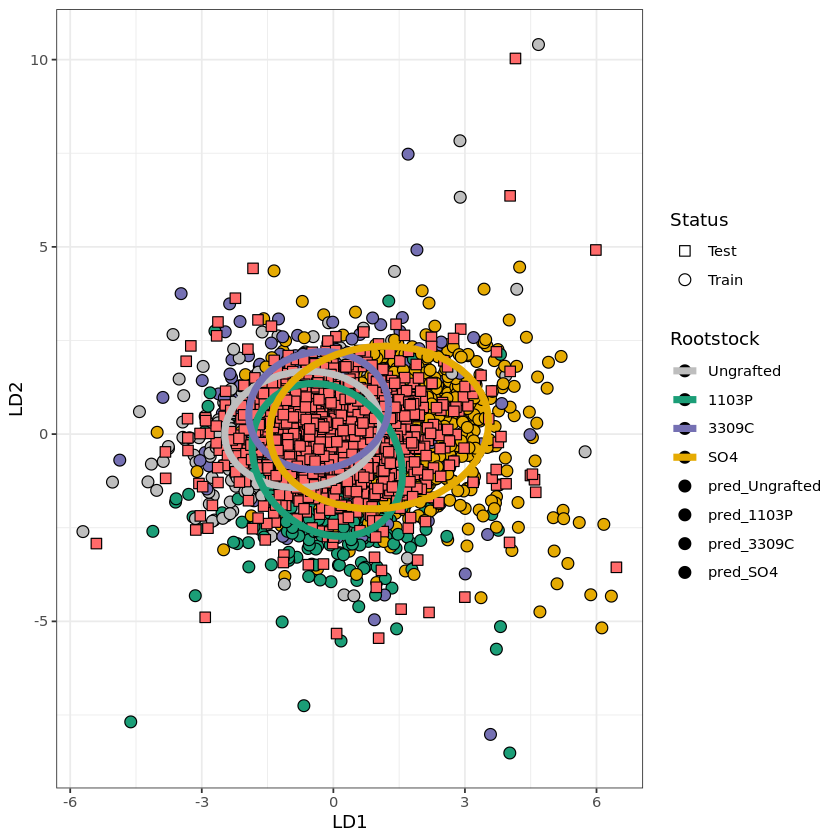

In [21]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, rootstock)

# separate into 80/20 train/test split
X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$rootstock
y_test <- X_test$rootstock

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$rootstock <- NULL
X_test$rootstock <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Rootstock <- y_train

lda.rs <- ggplot(d, aes(x=LD1, y=LD2, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 4)) + 
  scale_fill_manual(values=rs_palette) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=rs_palette) + 
  theme_bw()
lda.rs

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Rootstock <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Rootstock <- factor(d_pred$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4', 'pred_Ungrafted', 'pred_1103P', 'pred_3309C', 'pred_SO4'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.rs.pred <- ggplot(d_pred, aes(x=LD1, y=LD2, fill=Rootstock, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(rs_palette, 'indianred1', 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=c(rs_palette, NA, NA, NA, NA)) + 
  theme_bw()
lda.rs.pred

pdf('figures/LDA/lda_rs_l1_l2.pdf')
  lda.rs
dev.off()
pdf('figures/LDA/lda_rs_l1_l2_pred.pdf')
  lda.rs.pred
dev.off()

In [22]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
rs_overall <- as.data.frame(cm$overall)
rs_byclass <- as.data.frame(cm$byClass)
write.csv(rs_overall,file="figures/LDA/lda_rs_l1_l2_cm_overall.csv")
write.csv(rs_byclass,file="figures/LDA/lda_rs_l1_l2_cm_byclass.csv")

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted       240    46    69  28
  1103P            61   216    61  29
  3309C            72    29   235  33
  SO4              30    47    52 217

Overall Statistics
                                          
               Accuracy : 0.6198          
                 95% CI : (0.5944, 0.6447)
    No Information Rate : 0.2846          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.4925          
                                          
 Mcnemar's Test P-Value : 0.00115         

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                    0.5955       0.6391       0.5635     0.7068
Specificity                    0.8653       0.8660       0.8721     0.8886
Pos Pred Value                 0.6266       0.5886       0.6369     0.6272
Neg Pred Value            

##### ld1 x ld3

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


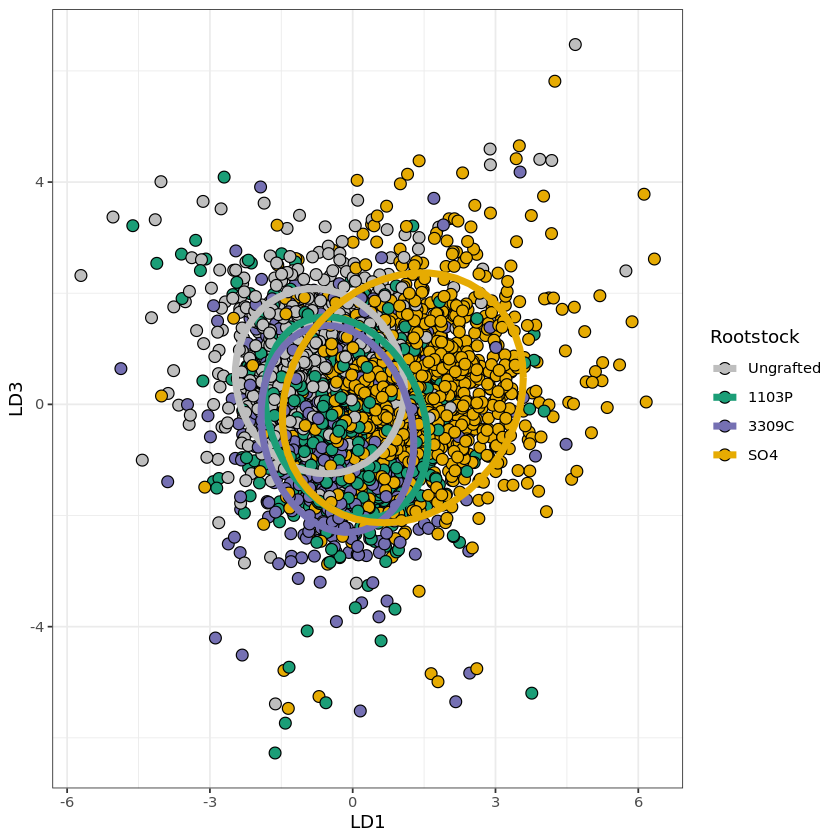

png 
  2

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


png 
  2

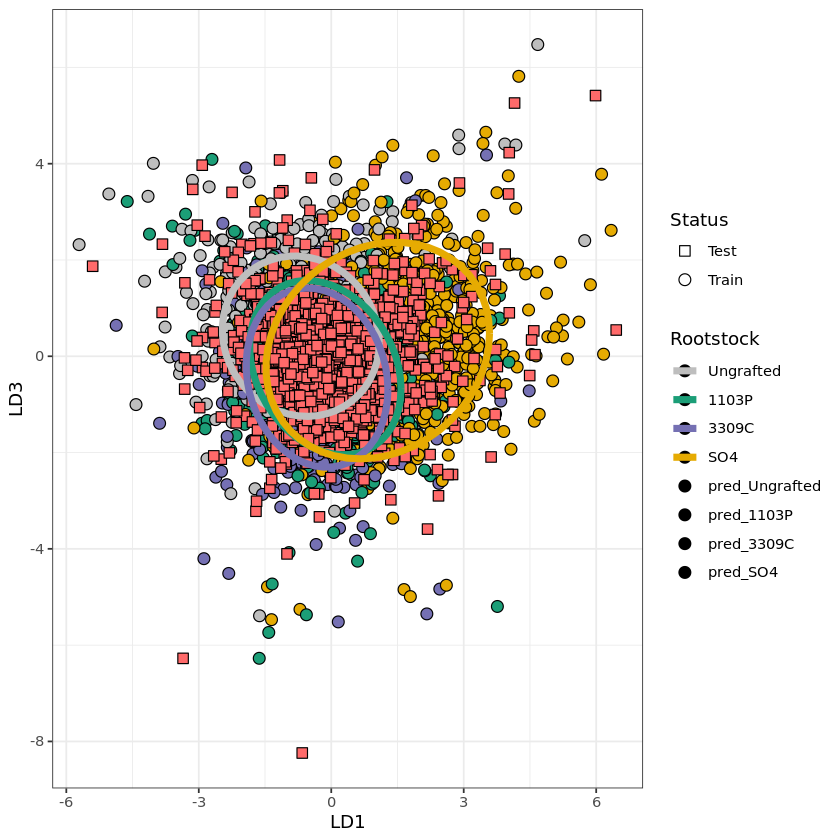

In [23]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, rootstock)

# separate into 80/20 train/test split
X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$rootstock
y_test <- X_test$rootstock

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$rootstock <- NULL
X_test$rootstock <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Rootstock <- y_train

lda.rs <- ggplot(d, aes(x=LD1, y=LD3, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 4)) + 
  scale_fill_manual(values=rs_palette) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=rs_palette) + 
  theme_bw()
lda.rs

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Rootstock <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Rootstock <- factor(d_pred$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4', 'pred_Ungrafted', 'pred_1103P', 'pred_3309C', 'pred_SO4'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.rs.pred <- ggplot(d_pred, aes(x=LD1, y=LD3, fill=Rootstock, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(rs_palette, 'indianred1', 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=c(rs_palette, NA, NA, NA, NA)) + 
  theme_bw()
lda.rs.pred

pdf('figures/LDA/lda_rs_l1_l3.pdf')
  lda.rs
dev.off()
pdf('figures/LDA/lda_rs_l1_l3_pred.pdf')
  lda.rs.pred
dev.off()

In [24]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
rs_overall <- as.data.frame(cm$overall)
rs_byclass <- as.data.frame(cm$byClass)
write.csv(rs_overall,file="figures/LDA/lda_rs_l1_l3_cm_overall.csv")
write.csv(rs_byclass,file="figures/LDA/lda_rs_l1_l3_cm_byclass.csv")

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted       240    46    69  28
  1103P            61   216    61  29
  3309C            72    29   235  33
  SO4              30    47    52 217

Overall Statistics
                                          
               Accuracy : 0.6198          
                 95% CI : (0.5944, 0.6447)
    No Information Rate : 0.2846          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.4925          
                                          
 Mcnemar's Test P-Value : 0.00115         

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                    0.5955       0.6391       0.5635     0.7068
Specificity                    0.8653       0.8660       0.8721     0.8886
Pos Pred Value                 0.6266       0.5886       0.6369     0.6272
Neg Pred Value            

##### ld2 x ld3

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


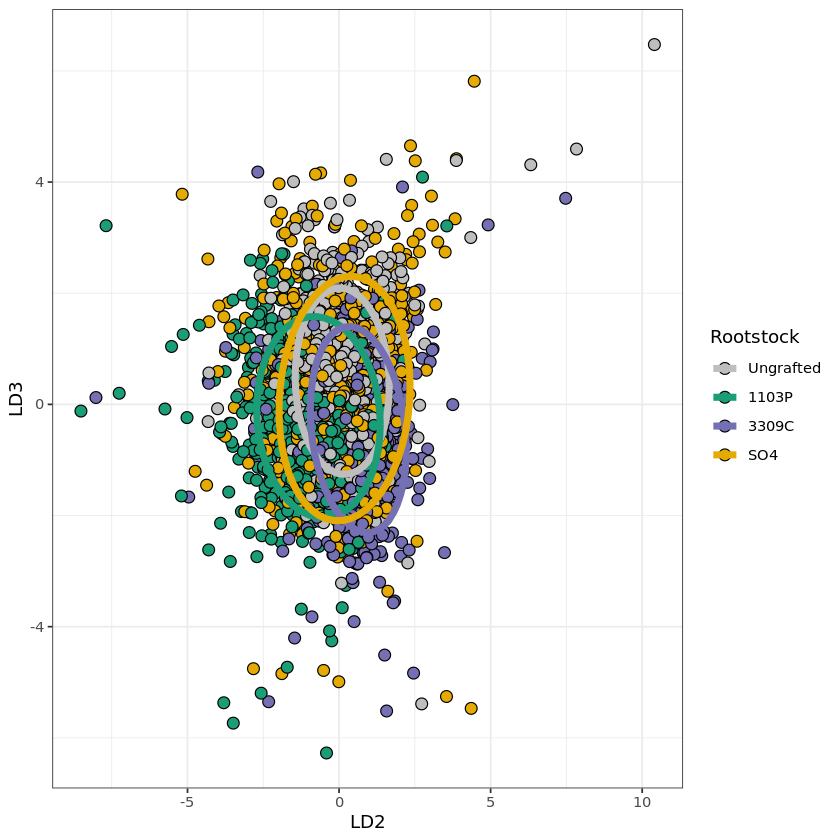

png 
  2

Warning message:
“Removed 208 row(s) containing missing values (geom_path).”


png 
  2

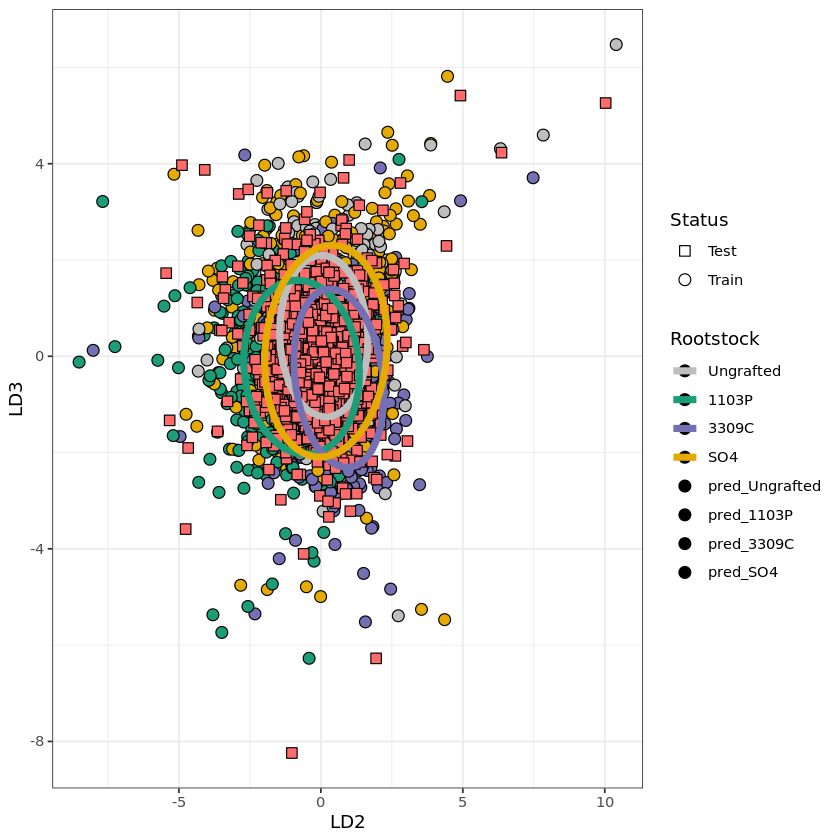

In [25]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, rootstock)

# separate into 80/20 train/test split
X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$rootstock
y_test <- X_test$rootstock

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$rootstock <- NULL
X_test$rootstock <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$Rootstock <- y_train

lda.rs <- ggplot(d, aes(x=LD2, y=LD3, fill=Rootstock, shape=Rootstock)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 4)) + 
  scale_fill_manual(values=rs_palette) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=rs_palette) + 
  theme_bw()
lda.rs

pred <- predict(lda, X_test)

d_pred <- rbind(as.data.frame(lda_plot$x), as.data.frame(pred$x))
d_pred$Rootstock <- c(as.vector(y_train), paste('pred_', as.vector(y_test), sep=''))
d_pred$Rootstock <- factor(d_pred$Rootstock, levels=c('Ungrafted', '1103P', '3309C', 'SO4', 'pred_Ungrafted', 'pred_1103P', 'pred_3309C', 'pred_SO4'))
d_pred$Status <- c(rep('Train', length(y_train)), rep('Test', length(y_test)))

lda.rs.pred <- ggplot(d_pred, aes(x=LD2, y=LD3, fill=Rootstock, shape=Status)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=c(22, 21)) + 
  scale_fill_manual(values=c(rs_palette, 'indianred1', 'indianred1', 'indianred1', 'indianred1')) + 
  stat_ellipse(aes(color=Rootstock), lwd=2) + 
  scale_color_manual(values=c(rs_palette, NA, NA, NA, NA)) + 
  theme_bw()
lda.rs.pred

pdf('figures/LDA/lda_rs_l2_l3.pdf')
  lda.rs
dev.off()
pdf('figures/LDA/lda_rs_l2_l3_pred.pdf')
  lda.rs.pred
dev.off()

In [26]:
cm <- caret::confusionMatrix(y_test, pred$class)
cm
rs_overall <- as.data.frame(cm$overall)
rs_byclass <- as.data.frame(cm$byClass)
write.csv(rs_overall,file="figures/LDA/lda_rs_l2_l3_cm_overall.csv")
write.csv(rs_byclass,file="figures/LDA/lda_rs_l2_l3_cm_byclass.csv")

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted       240    46    69  28
  1103P            61   216    61  29
  3309C            72    29   235  33
  SO4              30    47    52 217

Overall Statistics
                                          
               Accuracy : 0.6198          
                 95% CI : (0.5944, 0.6447)
    No Information Rate : 0.2846          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.4925          
                                          
 Mcnemar's Test P-Value : 0.00115         

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                    0.5955       0.6391       0.5635     0.7068
Specificity                    0.8653       0.8660       0.8721     0.8886
Pos Pred Value                 0.6266       0.5886       0.6369     0.6272
Neg Pred Value            

### rootstock x phenology

png 
  2

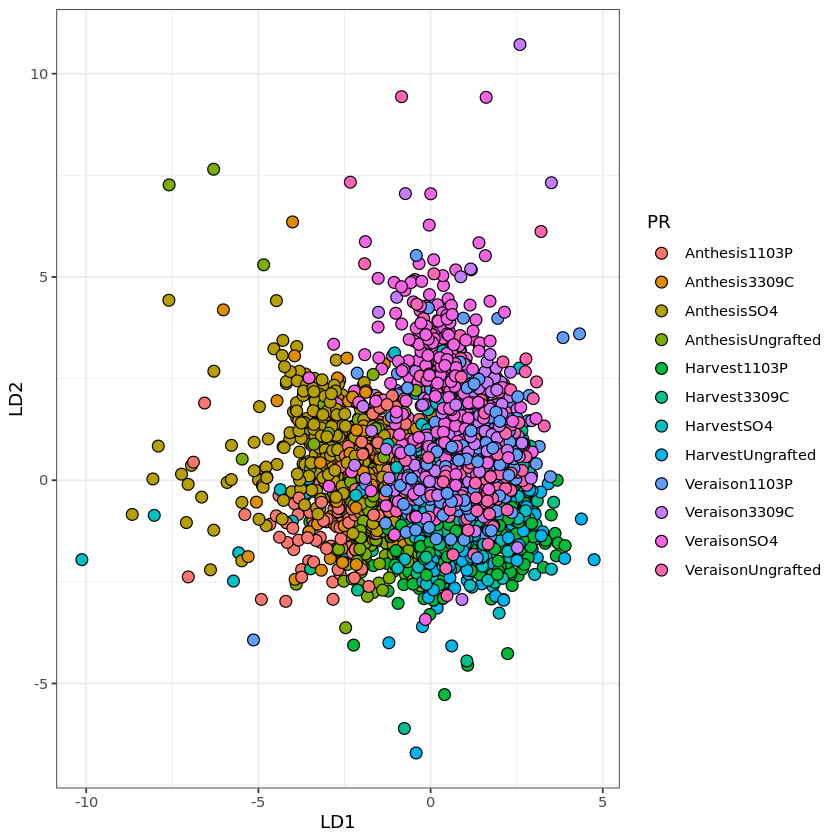

In [27]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, phenology, rootstock)

data$PR <- paste(data$phenology, data$rootstock, sep='')
data$phenology <- NULL
data$rootstock <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$PR
y_test <- X_test$PR

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$PR <- NULL
X_test$PR <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$PR <- y_train

lda.rs.pheno <- ggplot(d, aes(x=LD1, y=LD2, fill=PR, shape=PR)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=PR), lwd=2) +  
  theme_bw()
lda.rs.pheno

pdf('figures/LDA/lda_rs_pheno.pdf')
  lda.rs.pheno
dev.off()

In [28]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
rs_pheno_overall <- as.data.frame(cm$overall)
rs_pheno_byclass <- as.data.frame(cm$byClass)
write.csv(rs_pheno_overall,file="figures/LDA/lda_rs_pheno_cm_overall.csv")
write.csv(rs_pheno_byclass,file="figures/LDA/lda_rs_pheno_cm_byclass.csv")

Confusion Matrix and Statistics

                   Reference
Prediction          Anthesis1103P Anthesis3309C AnthesisSO4 AnthesisUngrafted
  Anthesis1103P                80             6           8                14
  Anthesis3309C                13            73           8                27
  AnthesisSO4                  17            24          62                 9
  AnthesisUngrafted            14            13          13                83
  Harvest1103P                  4             3           0                 2
  Harvest3309C                  2             2           0                 2
  HarvestSO4                    6             2           4                 6
  HarvestUngrafted              0             1           0                 1
  Veraison1103P                 2             1           2                 2
  Veraison3309C                 1             6           0                 2
  VeraisonSO4                   3             3           3                 2
  

### rootstock x year

png 
  2

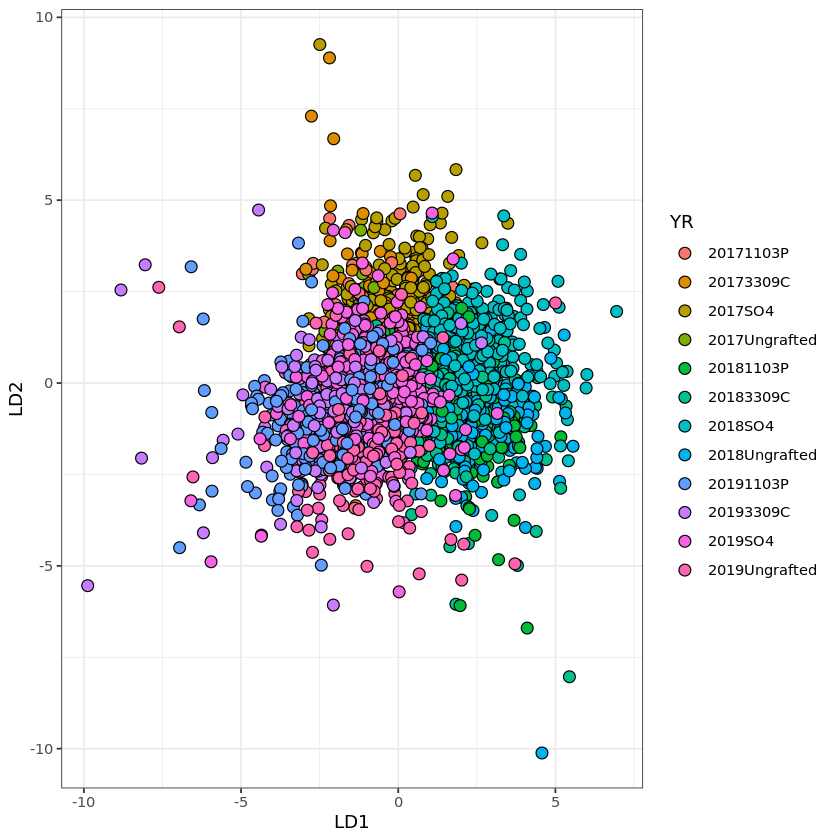

In [29]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, year, rootstock)

data$YR <- paste(data$year, data$rootstock, sep='')
data$year <- NULL
data$rootstock <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$YR
y_test <- X_test$YR

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$YR <- NULL
X_test$YR <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$YR <- y_train

lda.rs.year <- ggplot(d, aes(x=LD1, y=LD2, fill=YR, shape=YR)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=YR), lwd=2) +  
  theme_bw()
lda.rs.year

pdf('figures/LDA/lda_rs_year.pdf')
  lda.rs.year
dev.off()

In [30]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
rs_year_overall <- as.data.frame(cm$overall)
rs_year_byclass <- as.data.frame(cm$byClass)
write.csv(rs_year_overall,file="figures/LDA/lda_rs_year_cm_overall.csv")
write.csv(rs_year_byclass,file="figures/LDA/lda_rs_year_cm_byclass.csv")

Confusion Matrix and Statistics

               Reference
Prediction      20171103P 20173309C 2017SO4 2017Ungrafted 20181103P 20183309C
  20171103P            69        19      10            17         2         0
  20173309C             8        79      13            18         0         6
  2017SO4              18        19      60             6         0         3
  2017Ungrafted         8        16       4            61         0         2
  20181103P             7         0       0             7        73        18
  20183309C             2        14       2             5         5        61
  2018SO4               0         0       3             0         9        19
  2018Ungrafted         0         0       1            10        12        24
  20191103P             6         1       1             7         3         4
  20193309C             4        15       1            12         0         5
  2019SO4               5         8       6             4         1         2
  2019

### rootstock x leaf position

png 
  2

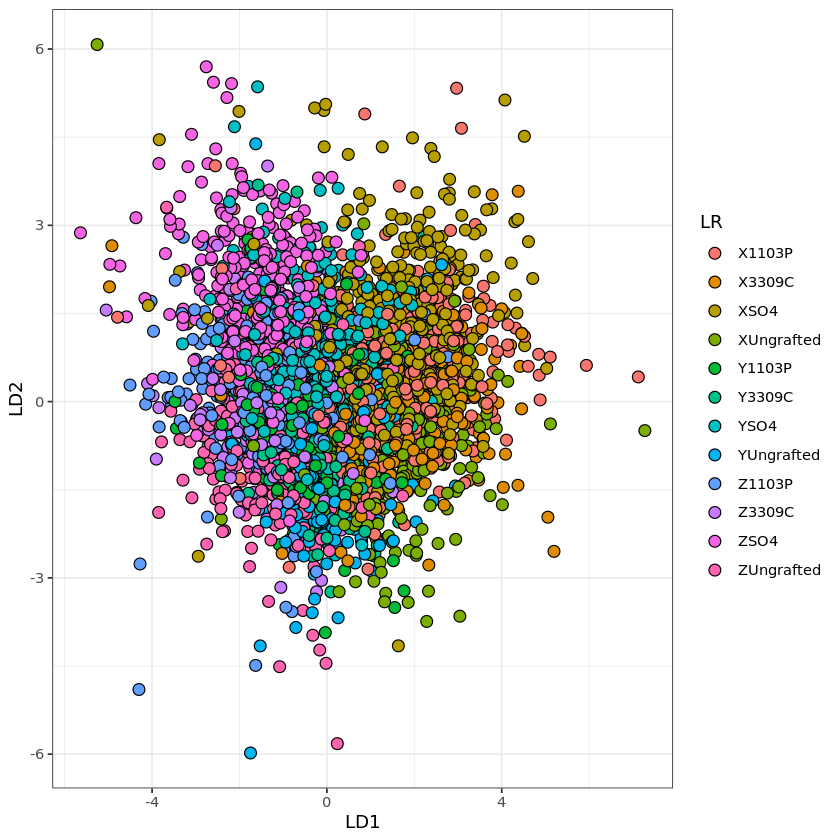

In [31]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, leafpos, rootstock)

data$LR <- paste(data$leafpos, data$rootstock, sep='')
data$leafpos <- NULL
data$rootstock <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$LR
y_test <- X_test$LR

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$LR <- NULL
X_test$LR <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$LR <- y_train

lda.rs.leafpos <- ggplot(d, aes(x=LD1, y=LD2, fill=LR, shape=LR)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=LR), lwd=2) +  
  theme_bw()
lda.rs.leafpos

pdf('figures/LDA/lda_rs_leafpos.pdf')
  lda.rs.leafpos
dev.off()

In [32]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
rs_leafpos_overall <- as.data.frame(cm$overall)
rs_leafpos_byclass <- as.data.frame(cm$byClass)
write.csv(rs_leafpos_overall,file="figures/LDA/lda_rs_leafpos_cm_overall.csv")
write.csv(rs_leafpos_byclass,file="figures/LDA/lda_rs_leafpos_cm_byclass.csv")

Confusion Matrix and Statistics

            Reference
Prediction   X1103P X3309C XSO4 XUngrafted Y1103P Y3309C YSO4 YUngrafted Z1103P
  X1103P         49     14    7          6      6     14    2          8      2
  X3309C         13     34   12         12      2     16    4         15      0
  XSO4            9     16   47         11      2      9   19          1      0
  XUngrafted     13     21   15         45      1      8    2         26      2
  Y1103P         10      1    0          8     61     15    8         16      7
  Y3309C          3      3    1          6      7     76    6         17      2
  YSO4            0      0    5          3      9     11   48          6      4
  YUngrafted      0      1    2          7      7     13    7         60      2
  Z1103P          2      1    0          1      7      7    1          2     62
  Z3309C          0      2    1          1      2     16    3          2      6
  ZSO4            0      1    1          0      6      2   10    

### year x phenology

png 
  2

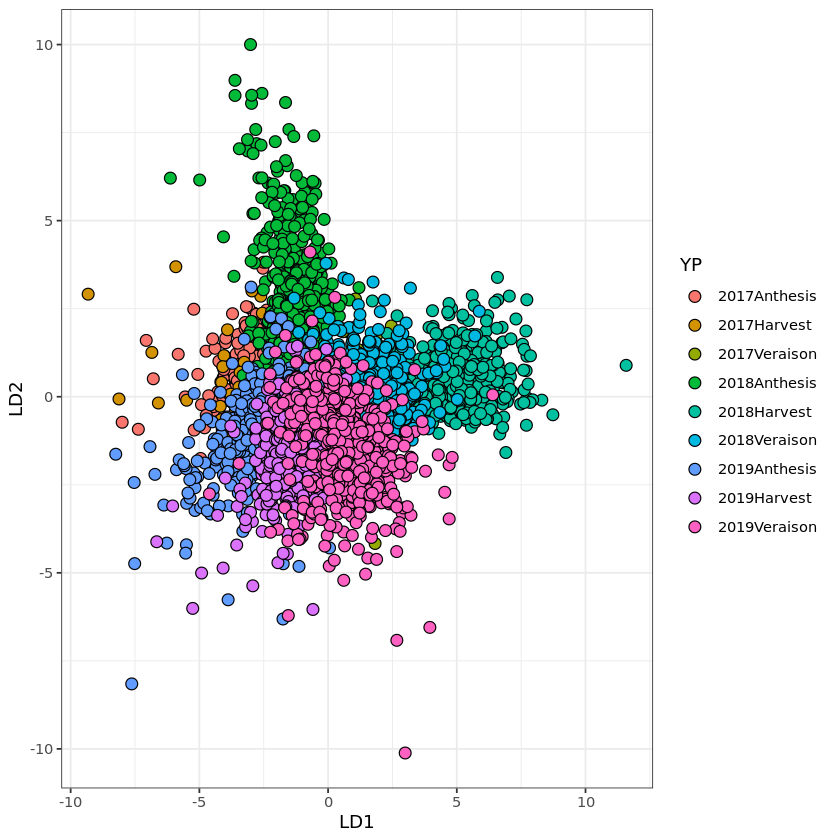

In [33]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, year, phenology)

data$YP <- paste(data$year, data$phenology, sep='')
data$year <- NULL
data$phenology <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$YP
y_test <- X_test$YP

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$YP <- NULL
X_test$YP <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$YP <- y_train

lda.year.phenology <- ggplot(d, aes(x=LD1, y=LD2, fill=YP, shape=YP)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=YP), lwd=2) +  
  theme_bw()
lda.year.phenology

pdf('figures/LDA/lda_year_phenology.pdf')
  lda.year.phenology
dev.off()

In [34]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
year_phenology_overall <- as.data.frame(cm$overall)
year_phenology_byclass <- as.data.frame(cm$byClass)
write.csv(year_phenology_overall,file="figures/LDA/lda_year_phenology_cm_overall.csv")
write.csv(year_phenology_byclass,file="figures/LDA/lda_year_phenology_cm_byclass.csv")

Confusion Matrix and Statistics

              Reference
Prediction     2017Anthesis 2017Harvest 2017Veraison 2018Anthesis 2018Harvest
  2017Anthesis          137          10            0            3           0
  2017Harvest             9         131            1            2           0
  2017Veraison            1           7          161            2           0
  2018Anthesis            1          14            0          155           0
  2018Harvest             0           0            5            0         156
  2018Veraison            0           1            6            1           1
  2019Anthesis           18          27            1            0           0
  2019Harvest             2          16            0            0           0
  2019Veraison            3           7            6            3           0
              Reference
Prediction     2018Veraison 2019Anthesis 2019Harvest 2019Veraison
  2017Anthesis            0           18           2            0
  2017H

### year x leaf position

png 
  2

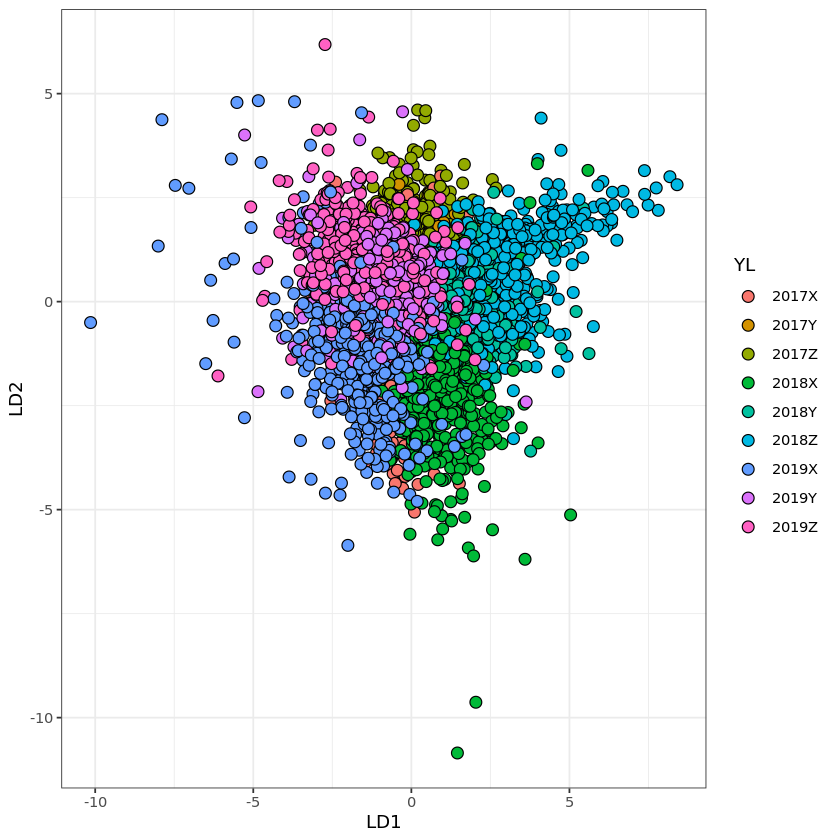

In [35]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, year, leafpos)

data$YL <- paste(data$year, data$leafpos, sep='')
data$year <- NULL
data$leafpos <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$YL
y_test <- X_test$YL

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$YL <- NULL
X_test$YL <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$YL <- y_train

lda.year.leafpos <- ggplot(d, aes(x=LD1, y=LD2, fill=YL, shape=YL)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=YL), lwd=2) +  
  theme_bw()
lda.year.leafpos

pdf('figures/LDA/lda_year_leafpos.pdf')
  lda.year.leafpos
dev.off()

In [36]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
year_leafpos_overall <- as.data.frame(cm$overall)
year_leafpos_byclass <- as.data.frame(cm$byClass)
write.csv(year_leafpos_overall,file="figures/LDA/lda_year_leafpos_cm_overall.csv")
write.csv(year_leafpos_byclass,file="figures/LDA/lda_year_leafpos_cm_byclass.csv")

Confusion Matrix and Statistics

          Reference
Prediction 2017X 2017Y 2017Z 2018X 2018Y 2018Z 2019X 2019Y 2019Z
     2017X    82    47     2    17     4     0    18     3     0
     2017Y     6   119    14     0     6     1     7     6     0
     2017Z     1    24   128     0     3     5     0     3     7
     2018X    11     1     0    97    31     1     7     2     0
     2018Y     1    24     0    11   114    20     1     0     0
     2018Z     0     3     2     7    35   111     0     0     2
     2019X    13    13     3     5     2     0    83    26    12
     2019Y     4    29     3     2    11     2    22    62    34
     2019Z     1     5     9     0     2     2     9    26   101

Overall Statistics
                                          
               Accuracy : 0.6123          
                 95% CI : (0.5868, 0.6373)
    No Information Rate : 0.1809          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  K

### phenology x leaf position

png 
  2

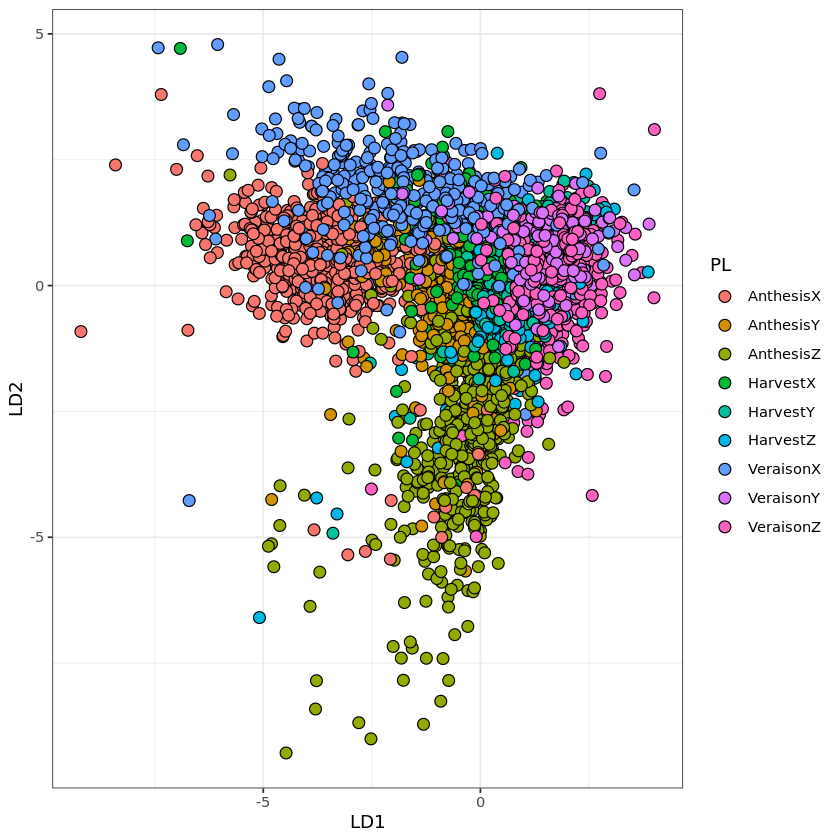

In [37]:
# select only ions
data <- vif %>% dplyr::select(B:Cd, samplename, phenology, leafpos)

data$PL <- paste(data$phenology, data$leafpos, sep='')
data$phenology <- NULL
data$leafpos <- NULL

X_train <- data[train_idx,]
X_test <- data[test_idx,]
y_train <- X_train$PL
y_test <- X_test$PL

X_train$samplename <- NULL
X_test$samplename <- NULL
X_train$PL <- NULL
X_test$PL <- NULL

lda <- MASS::lda(x=X_train, grouping=y_train)
lda_plot <- predict(lda, X_train)

d <- as.data.frame(lda_plot$x)
d$PL <- y_train

lda.phenology.leafpos <- ggplot(d, aes(x=LD1, y=LD2, fill=PL, shape=PL)) + 
  geom_point(size=3) + 
  scale_shape_manual(values=rep(21, 12)) + 
  #stat_ellipse(aes(color=PL), lwd=2) +  
  theme_bw()
lda.phenology.leafpos

pdf('figures/LDA/lda_phenology_leafpos.pdf')
  lda.phenology.leafpos
dev.off()

In [38]:
pred <- predict(lda, X_test)
cm <- caret::confusionMatrix(as.factor(y_test), pred$class)
cm
phenology_leafpos_overall <- as.data.frame(cm$overall)
phenology_leafpos_byclass <- as.data.frame(cm$byClass)
write.csv(phenology_leafpos_overall,file="figures/LDA/lda_phenology_leafpos_cm_overall.csv")
write.csv(phenology_leafpos_byclass,file="figures/LDA/lda_phenology_leafpos_cm_byclass.csv")

Confusion Matrix and Statistics

           Reference
Prediction  AnthesisX AnthesisY AnthesisZ HarvestX HarvestY HarvestZ VeraisonX
  AnthesisX       152         3         3        1        1        0         5
  AnthesisY         6       142        13        3        4        1        10
  AnthesisZ         2        23       129        1        1        8         0
  HarvestX          1        34         1       79       19        8         9
  HarvestY          0        14         0       21       69       27         0
  HarvestZ          0         8         5       10       25       92         0
  VeraisonX        21         5         0        8       25        0        76
  VeraisonY         0         0         2        1       19        3         4
  VeraisonZ         0         0         1        0        3       17         0
           Reference
Prediction  VeraisonY VeraisonZ
  AnthesisX         0         0
  AnthesisY         2         1
  AnthesisZ         1         1
  Harve